In [5]:
#!/usr/bin/env python
# coding: utf-8
__docformat__ = 'reStructuredText'
###########################################
# Imports
###########################################


from sys import exit
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import scipy.signal
from scipy.interpolate import interp1d
import xarray as xr
import time as TIME
import xrft as xrft
from scipy.interpolate import griddata
import matplotlib.colors as colors

from matplotlib.ticker import MaxNLocator


plt.rcParams['text.usetex'] = True
#plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.facecolor':'white'})
plt.rcParams.update({'savefig.facecolor':'white'})
###########################################


#cases = ['WANG1_NR','WANG1_FR','WANG1_lat_90','W005_C500_NO_COR','WANG1_FR_domain_div_2','WANG1_FR_10f2']
cases = ['WANG1_FR_no_mld']

les = {}
LG_MEAN={}
LG_RES={}
LG_SBG={}
BU_KE={}

for case in cases:
    file = 'GN_01.1.OC_01.000.nc'
    path = '../data/'+case+'/'
    print('opening '+path+file)
    les[case] = xr.open_dataset(path+file)
    LG_MEAN[case]= xr.open_dataset(path+file,group ='/LES_budgets/Mean/Cartesian/Not_time_averaged/Not_normalized/cart')
    LG_RES[case] = xr.open_dataset(path+file,group ='/LES_budgets/Resolved/Cartesian/Not_time_averaged/Not_normalized/cart')    
    LG_SBG[case] = xr.open_dataset(path+file,group ='/LES_budgets/Subgrid/Cartesian/Not_time_averaged/Not_normalized/cart')
    BU_KE[case] = xr.open_dataset(path+file,group ='/LES_budgets/BU_KE/Cartesian/Not_time_averaged/Not_normalized/cart')


opening ../data/WANG1_FR_no_mld/GN_01.1.OC_01.000.nc


In [6]:
z_r = {}
time_les = les[case].time_les 
time = (((time_les - time_les[0]) / np.timedelta64(1, 'h')).data.astype(int) + 1)*np.timedelta64(1, 'h') #numpy array of integer hours, starting at inital time + 1h
z_r['les'] = (les[case].level_les - (les[case].level_les[0] + les[case].level_les[-1])).data #remap level_les on negative depth values


In [12]:
mld_les = np.zeros(len(time))

for instant in range(len(time)):
    mld_les[instant] = z_r['les'][(-LG_RES[case]['RES_WTH'][instant]).argmax()]


#open scm
run_params ={'output_filename': 'scm_'+case+'.nc'}
print('opening '+run_params['output_filename'])
scm = xr.open_dataset(run_params['output_filename'])
z_r['scm'] = scm['z_r'] 

#open scm
run_params ={'output_filename': 'scm_EVD_'+case+'.nc'}
print('opening '+run_params['output_filename'])
scm_evd = xr.open_dataset(run_params['output_filename'])


opening scm_WANG1_FR_no_mld.nc
opening scm_EVD_WANG1_FR_no_mld.nc


In [8]:
def interpolate_les_on_scm(X_les, z_les, z_scm):
    # Interpolate les on scm grid. 
    # If les points are out out scm grid, NaNs are put 
    X_les_int = griddata(z_les, X_les, z_scm, method='linear')

    # Find indices of non-NaN values in X_les_int
    valid_indices = ~np.isnan(X_les_int[:,0])

    # Filter X_les_int and z_scm based on valid indices
    X_les_int_filtered = X_les_int[valid_indices]
    z_scm_filtered = z_scm[valid_indices] 

    return X_les_int_filtered, z_scm_filtered, valid_indices



In [9]:
TH_les = griddata(z_r['les'],LG_MEAN[case]['MEAN_TH'].T,z_r['scm']).T
TH_les.shape

(276, 450)

In [10]:
TH['scm'].shape

NameError: name 'TH' is not defined

In [13]:
TH = {}
TH['les'] = griddata(z_r['les'],LG_MEAN[case]['MEAN_TH'].T,z_r['scm']).T - 273.15
TH['scm'] = scm['temp'][1:]
TH['scm_evd'] = scm_evd['temp'][1:]

KeyError: 'scm_nr'

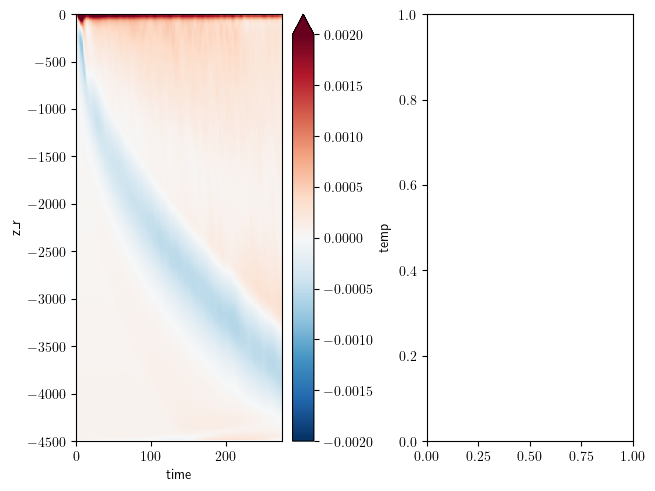

In [14]:
fig,axs = plt.subplots(nrows=1,ncols=2,constrained_layout=True)
(TH['scm']-TH['les']).T.plot(ax=axs.flat[0],vmin=-0.002,vmax=0.002, cmap=plt.cm.RdBu_r)
(TH['scm_nr']-TH['les']).T.plot(ax=axs.flat[1],vmin=-0.002,vmax=0.002, cmap=plt.cm.RdBu_r)

axs.flat[0].set_xlabel(r'time')
axs.flat[0].set_ylabel(r'$z$')

Text(0, 0.5, '$z$')

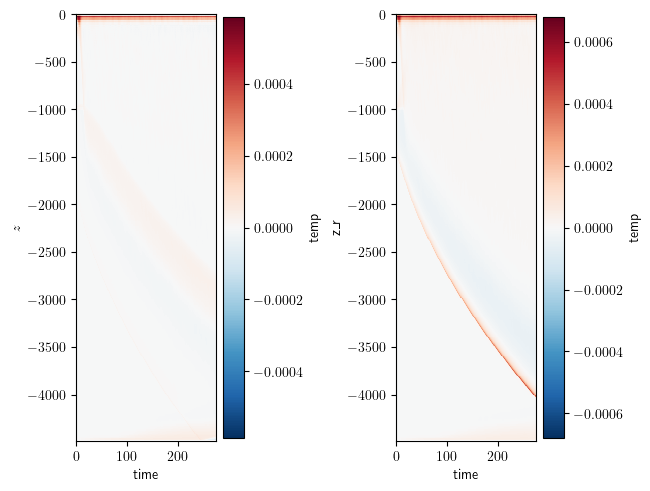

In [ ]:
fig,axs = plt.subplots(nrows=1,ncols=2,constrained_layout=True)
((TH['scm']-TH['les'])).diff('z_r').T.plot(ax=axs.flat[0], cmap=plt.cm.RdBu_r)
((TH['scm_nr']-TH['les'])).diff('z_r').T.plot(ax=axs.flat[1], cmap=plt.cm.RdBu_r)

axs.flat[0].set_xlabel(r'time')
axs.flat[0].set_ylabel(r'$z$')

In [ ]:
axs[0]

array([<Axes: >, <Axes: >], dtype=object)

In [ ]:
for k in range(4):
    instant=40//4*(k+1) -1
    print(instant)

9
19
29
39


In [17]:
mld

NameError: name 'mld' is not defined

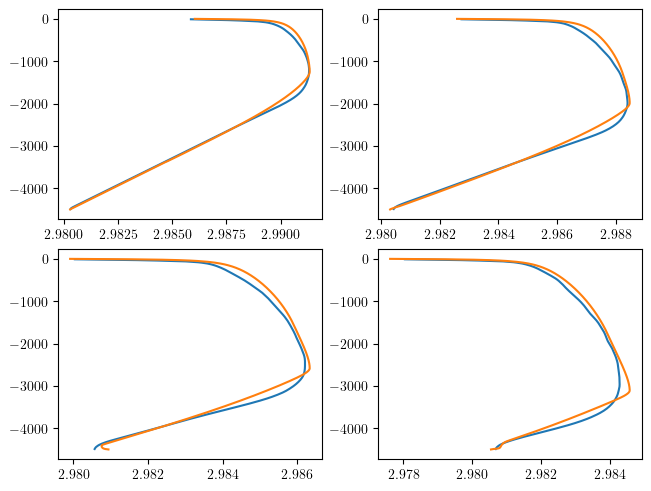

In [ ]:
fig,axs = plt.subplots(nrows=2,ncols=2,constrained_layout=True)

for k,ax in enumerate(axs.flat):
    instant=len(time)//(len(axs.flat))*(k+1) -1
    
    ax.plot(TH['les'][instant], z_r['scm'])
    ax.plot(TH['scm'][instant], z_r['scm'])




# (TH['scm_nr']-TH['les']).T.plot(ax=axs,vmin=-0.002,vmax=0.002, cmap=plt.cm.RdBu_r)

# axs.flat[0].set_xlabel(r'time')
# axs.flat[0].set_ylabel(r'$z$')

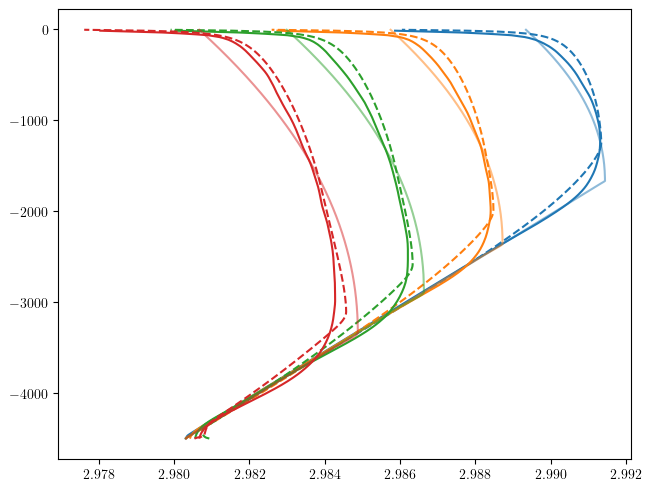

In [16]:
fig,axs = plt.subplots(nrows=1,ncols=1,constrained_layout=True)

ax=axs
nb_plots = 4
for k in range(nb_plots):
    instant=len(time)//(nb_plots)*(k+1) -1
    
    p=ax.plot(TH['les'][instant], z_r['scm'])
    color = p[0].get_color()
    ax.plot(TH['scm'][instant], z_r['scm'],color=color,linestyle='--')
    ax.plot(TH['scm_evd'][instant], z_r['scm'],color=color,linestyle='-',alpha=0.5)





# (TH['scm_nr']-TH['les']).T.plot(ax=axs,vmin=-0.002,vmax=0.002, cmap=plt.cm.RdBu_r)

# axs.flat[0].set_xlabel(r'time')
# axs.flat[0].set_ylabel(r'$z$')

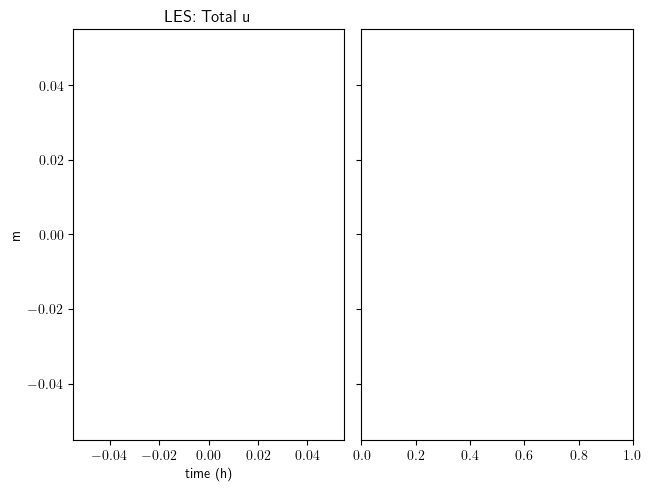

In [ ]:

time_mesh, z_r_mesh = np.meshgrid(time, z_r['scm'])

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, layout='constrained')
i=-1
#-----------------------------------------------------
i+=1; ax = axs.flat[i]
ax.set_title('LES: Total u')
ax.set_xlabel('time (h)')
ax.set_ylabel(r'm')
var=TH['scm']-TH['les']
ax.contourf( var.T,time_mesh, z_r_mesh, cmap=plt.cm.RdBu_r)

In [ ]:
TH['les'] = LG_MEAN['WANG1_FR']['MEAN_TH'].interp_like(TH['scm'])

In [ ]:
TH['les']

<xarray.DataArray 'MEAN_TH' (time_les: 276, level_les: 180)>
array([[276.13027 , 276.13041 , 276.130551, ..., 276.149942, 276.149447,
        276.148065],
       [276.130271, 276.13041 , 276.130551, ..., 276.149508, 276.148608,
        276.146635],
       [276.130273, 276.13041 , 276.130551, ..., 276.148853, 276.147583,
        276.145416],
       ...,
       [276.130823, 276.130835, 276.130858, ..., 276.135299, 276.13429 ,
        276.13221 ],
       [276.130824, 276.130837, 276.130859, ..., 276.135234, 276.134208,
        276.132118],
       [276.130826, 276.130838, 276.13086 , ..., 276.135181, 276.134138,
        276.132035]])
Dimensions without coordinates: time_les, level_les
Attributes:
    long_name:  MEAN_TH (cart)
    units:      K
    comment:    Mean potential temperature Profile (cart)
    valid_min:  -1e+36
    valid_max:  1e+36

In [ ]:
(TH['scm']-TH['les']).plot()

MemoryError: Unable to allocate 46.1 GiB for an array with shape (277, 450, 276, 180) and data type float64

In [ ]:
TH['les'].shape

(448, 180)

In [ ]:
TH_les - TH['les']

ValueError: operands could not be broadcast together with shapes (276,180) (448,180) 

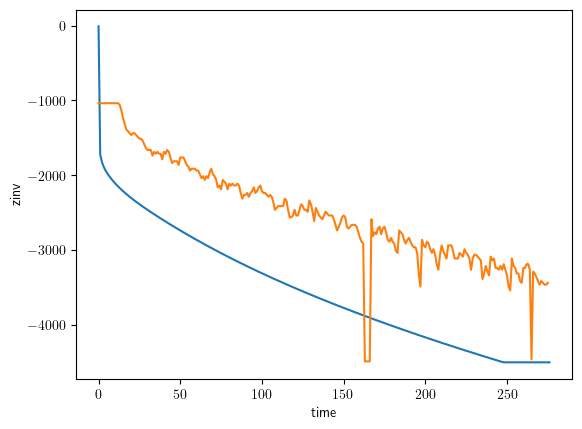

In [ ]:
(scm['zinv']).plot()
plt.plot(mld)

In [ ]:


mld = z_r_les[(-LG_MEAN[case]['MEAN_TH'][instant]).argmax()]

WU_les = LG_RES[case]['RES_WU'] + LG_SBG[case]['SBG_WU']
WV_les = LG_RES[case]['RES_WV'] + LG_SBG[case]['SBG_WV']    
dz_WU_les = (WU_les.mean(dim='time_les').data[1:]-WU_les.mean(dim='time_les').data[:-1])/(z_r_les.data[1:]-z_r_les.data[:-1])
dz_WV_les = (WV_les.mean(dim='time_les').data[1:]-WV_les.mean(dim='time_les').data[:-1])/(z_r_les.data[1:]-z_r_les.data[:-1])

zlim = mld - 50
zadim = z_r_les/(-mld)

#open scm
run_params ={'output_filename': 'scm_WANG1_FR.nc'}
print('opening '+run_params['output_filename'])
scm = xr.open_dataset(run_params['output_filename'])

dz_WU_scm = (scm['WU'].mean(dim='time').data[1:]-scm['WU'].mean(dim='time').data[:-1])/(scm['z_w'].data[1:]-scm['z_w'].data[:-1])
dz_WV_scm = (scm['WV'].mean(dim='time').data[1:]-scm['WV'].mean(dim='time').data[:-1])/(scm['z_w'].data[1:]-scm['z_w'].data[:-1])




    ############ Plotting
def plot_waves_panel():
    vmin=-0.004;vmax=0.004
    levels = MaxNLocator(nbins=15).tick_values(vmin,vmax)
    tt = (les[case]['time_les'] - les[case]['time_les'][0])/np.timedelta64(1,'h')+2 #array of hours


    time_les_mesh, z_les_mesh = np.meshgrid(tt, z_r_les)
    time_scm_r_mesh, z_scm_r_mesh= np.meshgrid(scm['ocean_time']/np.timedelta64(1,'h'), scm['z_r'])
    time_scm_w_mesh, z_scm_w_mesh= np.meshgrid(scm['ocean_time']/np.timedelta64(1,'h'), scm['z_w'])

    fig, axs = plt.subplots(nrows=4, ncols=3, sharey=True, layout='constrained', figsize=(10,13))
    i=-1
    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Total u')
    ax.set_xlabel('time (h)')
    ax.set_ylabel(r'm')
    var=LG_MEAN[case]['MEAN_U']
    ax.contourf( time_les_mesh, z_les_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Waves u')
    ax.set_xlabel('time (h)')
    var=LG_MEAN[case]['MEAN_U'] - LG_MEAN[case]['MEAN_U'].mean(dim='time_les')
    ax.contourf( time_les_mesh, z_les_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Mean flow u')
    ax.set_xlabel(r'$m s^{-1}$')
    var=LG_MEAN[case]['MEAN_U'].mean(dim='time_les')
    ax.plot( var.T, z_r_les,  label=r'$\overline{u}^{x,y,t}$')
    ax.plot( -1/(scm.attrs['fcorSIN'])*dz_WV_les , z_r_les_w_les,  color='black', linestyle=':', label=r'$-\frac{1}{f} \partial_z \overline{w^\prime v^\prime}^{x,y,t}$')
    ax.set_xlim(-0.004,0.004)
    ax.legend()


    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Total u')
    ax.set_xlabel('time (h)')
    ax.set_ylabel(r'm')
    var=scm['u']
    ax.contourf( time_scm_r_mesh, z_scm_r_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Waves u')
    ax.set_xlabel('time (h)')
    var=scm['u'] - scm['u'].mean(dim='time')
    ax.contourf( time_scm_r_mesh, z_scm_r_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Mean flow u')
    ax.set_xlabel(r'$m s^{-1}$')
    ax.plot( scm['u'][1:].mean(dim='time'), scm['z_r'], label=r'$\overline{u}^{x,y,t}$')
    ax.plot( 1/(scm.attrs['fcorSIN'])*dz_WV_scm , scm['z_r'],  color='black', linestyle=':', label=r'$\frac{1}{f} \partial_z \overline{w^\prime v^\prime}^{x,y,t}$')
    ax.set_xlim(-0.004,0.004)
    ax.legend()


    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Total v')
    ax.set_xlabel('time (h)')
    ax.set_ylabel(r'm')
    var=LG_MEAN[case]['MEAN_V']
    ax.contourf( time_les_mesh, z_les_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Waves v')
    ax.set_xlabel('time (h)')
    var=LG_MEAN[case]['MEAN_V'] - LG_MEAN[case]['MEAN_V'].mean(dim='time_les')
    im=ax.contourf( time_les_mesh, z_les_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Mean flow v')
    ax.set_xlabel(r'$m s^{-1}$')
    var=LG_MEAN[case]['MEAN_V'].mean(dim='time_les')
    ax.plot( var.T, z_r_les,  label=r'$\overline{v}^{x,y,t}$')
    ax.plot( 1/(scm.attrs['fcorSIN'])*dz_WU_les , z_r_les_w_les,  color='black', linestyle=':', label=r'$\frac{1}{f} \partial_z \overline{w^\prime u^\prime}^{x,y,t}$')
    ax.set_xlim(-0.004,0.004)
    ax.legend()


    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Total v')
    ax.set_xlabel('time (h)')
    ax.set_ylabel(r'm')
    var=scm['v']
    ax.contourf( time_scm_r_mesh, z_scm_r_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Waves v')
    ax.set_xlabel('time (h)')
    var=scm['v'] - scm['v'].mean(dim='time')
    ax.contourf( time_scm_r_mesh, z_scm_r_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Mean flow v')
    ax.set_xlabel(r'$m s^{-1}$')
    ax.plot( scm['v'][1:].mean(dim='time'), scm['z_r'], label=r'$\overline{v}^{x,y,t}$')
    ax.plot( -1/(scm.attrs['fcorSIN'])*dz_WU_scm , scm['z_r'],  color='black', linestyle=':', label=r'$\frac{1}{f} \partial_z \overline{w^\prime u^\prime}^{x,y,t}$')
    ax.set_xlim(-0.004,0.004)
    ax.legend()

    #-----------------------------------------------------
    for ax in axs.flat:
        ax.set_ylim(-3300,0)
        ax.set_box_aspect(1)

    #fig.colorbar(im, orientation="vertical" , ticks=np.linspace(vmin,vmax,9))
    plt.suptitle(case)

    saving_path = '../figures/WANG1_LES_vs_SCM_velocities.png'
    plt.savefig(saving_path, bbox_inches='tight', dpi=300)
    print('figure saved at '+saving_path)

    #plt.show()
plot_waves_panel()



def plot_mean_fluxes():
    WU_les_mean=WU_les.mean(dim='time_les')
    WV_les_mean=WV_les.mean(dim='time_les')

    WU_scm_mean=-scm['WU'].mean(dim='time')
    WV_scm_mean=-scm['WV'].mean(dim='time')



    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, layout='constrained')
    i=-1
    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title(r'$\overline{w^\prime u^\prime}$')
    ax.set_ylabel(r'$m$')
    ax.plot(WU_les_mean, z_r_les,label='LES')
    ax.plot(WU_scm_mean, scm['z_w'],label='SCM')
    ax.axvline(0.,color='k',alpha=1,linestyle='--',linewidth=1)
    ax.legend()
    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title(r'$\overline{w^\prime v^\prime}$')
    ax.set_ylabel(r'$m$')
    ax.plot(WV_les_mean, z_r_les,label='LES')
    ax.plot(WV_scm_mean, scm['z_w'],label='SCM')
    ax.axvline(0.,color='k',alpha=1,linestyle='--',linewidth=1)

    ax.legend()

    saving_path = '../figures/WANG1_LES_vs_SCM_momentum_flux_averaged.png'
    plt.savefig(saving_path, bbox_inches='tight', dpi=300)
    print('figure saved at '+saving_path)

#plot_mean_fluxes()

In [ ]:


WU_les = LG_RES[case]['RES_WU'] + LG_SBG[case]['SBG_WU']
WV_les = LG_RES[case]['RES_WV'] + LG_SBG[case]['SBG_WV']    
dz_WU_les = (WU_les.mean(dim='time_les').data[1:]-WU_les.mean(dim='time_les').data[:-1])/(z_r_les.data[1:]-z_r_les.data[:-1])
dz_WV_les = (WV_les.mean(dim='time_les').data[1:]-WV_les.mean(dim='time_les').data[:-1])/(z_r_les.data[1:]-z_r_les.data[:-1])

zlim = mld - 50
zadim = z_r_les/(-mld)

#open scm
run_params ={'output_filename': 'scm_WANG1_FR.nc'}
print('opening '+run_params['output_filename'])
scm = xr.open_dataset(run_params['output_filename'])

dz_WU_scm = (scm['WU'].mean(dim='time').data[1:]-scm['WU'].mean(dim='time').data[:-1])/(scm['z_w'].data[1:]-scm['z_w'].data[:-1])
dz_WV_scm = (scm['WV'].mean(dim='time').data[1:]-scm['WV'].mean(dim='time').data[:-1])/(scm['z_w'].data[1:]-scm['z_w'].data[:-1])




    ############ Plotting
def plot_waves_panel():
    vmin=-0.004;vmax=0.004
    levels = MaxNLocator(nbins=15).tick_values(vmin,vmax)
    tt = (les[case]['time_les'] - les[case]['time_les'][0])/np.timedelta64(1,'h')+2 #array of hours


    time_les_mesh, z_les_mesh = np.meshgrid(tt, z_r_les)
    time_scm_r_mesh, z_scm_r_mesh= np.meshgrid(scm['ocean_time']/np.timedelta64(1,'h'), scm['z_r'])
    time_scm_w_mesh, z_scm_w_mesh= np.meshgrid(scm['ocean_time']/np.timedelta64(1,'h'), scm['z_w'])

    fig, axs = plt.subplots(nrows=4, ncols=3, sharey=True, layout='constrained', figsize=(10,13))
    i=-1
    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Total u')
    ax.set_xlabel('time (h)')
    ax.set_ylabel(r'm')
    var=LG_MEAN[case]['MEAN_U']
    ax.contourf( time_les_mesh, z_les_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Waves u')
    ax.set_xlabel('time (h)')
    var=LG_MEAN[case]['MEAN_U'] - LG_MEAN[case]['MEAN_U'].mean(dim='time_les')
    ax.contourf( time_les_mesh, z_les_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Mean flow u')
    ax.set_xlabel(r'$m s^{-1}$')
    var=LG_MEAN[case]['MEAN_U'].mean(dim='time_les')
    ax.plot( var.T, z_r_les,  label=r'$\overline{u}^{x,y,t}$')
    ax.plot( -1/(scm.attrs['fcorSIN'])*dz_WV_les , z_r_les_w_les,  color='black', linestyle=':', label=r'$-\frac{1}{f} \partial_z \overline{w^\prime v^\prime}^{x,y,t}$')
    ax.set_xlim(-0.004,0.004)
    ax.legend()


    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Total u')
    ax.set_xlabel('time (h)')
    ax.set_ylabel(r'm')
    var=scm['u']
    ax.contourf( time_scm_r_mesh, z_scm_r_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Waves u')
    ax.set_xlabel('time (h)')
    var=scm['u'] - scm['u'].mean(dim='time')
    ax.contourf( time_scm_r_mesh, z_scm_r_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Mean flow u')
    ax.set_xlabel(r'$m s^{-1}$')
    ax.plot( scm['u'][1:].mean(dim='time'), scm['z_r'], label=r'$\overline{u}^{x,y,t}$')
    ax.plot( 1/(scm.attrs['fcorSIN'])*dz_WV_scm , scm['z_r'],  color='black', linestyle=':', label=r'$\frac{1}{f} \partial_z \overline{w^\prime v^\prime}^{x,y,t}$')
    ax.set_xlim(-0.004,0.004)
    ax.legend()


    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Total v')
    ax.set_xlabel('time (h)')
    ax.set_ylabel(r'm')
    var=LG_MEAN[case]['MEAN_V']
    ax.contourf( time_les_mesh, z_les_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Waves v')
    ax.set_xlabel('time (h)')
    var=LG_MEAN[case]['MEAN_V'] - LG_MEAN[case]['MEAN_V'].mean(dim='time_les')
    im=ax.contourf( time_les_mesh, z_les_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('LES: Mean flow v')
    ax.set_xlabel(r'$m s^{-1}$')
    var=LG_MEAN[case]['MEAN_V'].mean(dim='time_les')
    ax.plot( var.T, z_r_les,  label=r'$\overline{v}^{x,y,t}$')
    ax.plot( 1/(scm.attrs['fcorSIN'])*dz_WU_les , z_r_les_w_les,  color='black', linestyle=':', label=r'$\frac{1}{f} \partial_z \overline{w^\prime u^\prime}^{x,y,t}$')
    ax.set_xlim(-0.004,0.004)
    ax.legend()


    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Total v')
    ax.set_xlabel('time (h)')
    ax.set_ylabel(r'm')
    var=scm['v']
    ax.contourf( time_scm_r_mesh, z_scm_r_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Waves v')
    ax.set_xlabel('time (h)')
    var=scm['v'] - scm['v'].mean(dim='time')
    ax.contourf( time_scm_r_mesh, z_scm_r_mesh, var.T,vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.RdBu_r)

    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title('SCM: Mean flow v')
    ax.set_xlabel(r'$m s^{-1}$')
    ax.plot( scm['v'][1:].mean(dim='time'), scm['z_r'], label=r'$\overline{v}^{x,y,t}$')
    ax.plot( -1/(scm.attrs['fcorSIN'])*dz_WU_scm , scm['z_r'],  color='black', linestyle=':', label=r'$\frac{1}{f} \partial_z \overline{w^\prime u^\prime}^{x,y,t}$')
    ax.set_xlim(-0.004,0.004)
    ax.legend()

    #-----------------------------------------------------
    for ax in axs.flat:
        ax.set_ylim(-3300,0)
        ax.set_box_aspect(1)

    #fig.colorbar(im, orientation="vertical" , ticks=np.linspace(vmin,vmax,9))
    plt.suptitle(case)

    saving_path = '../figures/WANG1_LES_vs_SCM_velocities.png'
    plt.savefig(saving_path, bbox_inches='tight', dpi=300)
    print('figure saved at '+saving_path)

    #plt.show()
plot_waves_panel()



def plot_mean_fluxes():
    WU_les_mean=WU_les.mean(dim='time_les')
    WV_les_mean=WV_les.mean(dim='time_les')

    WU_scm_mean=-scm['WU'].mean(dim='time')
    WV_scm_mean=-scm['WV'].mean(dim='time')



    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, layout='constrained')
    i=-1
    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title(r'$\overline{w^\prime u^\prime}$')
    ax.set_ylabel(r'$m$')
    ax.plot(WU_les_mean, z_r_les,label='LES')
    ax.plot(WU_scm_mean, scm['z_w'],label='SCM')
    ax.axvline(0.,color='k',alpha=1,linestyle='--',linewidth=1)
    ax.legend()
    #-----------------------------------------------------
    i+=1; ax = axs.flat[i]
    ax.set_title(r'$\overline{w^\prime v^\prime}$')
    ax.set_ylabel(r'$m$')
    ax.plot(WV_les_mean, z_r_les,label='LES')
    ax.plot(WV_scm_mean, scm['z_w'],label='SCM')
    ax.axvline(0.,color='k',alpha=1,linestyle='--',linewidth=1)

    ax.legend()

    saving_path = '../figures/WANG1_LES_vs_SCM_momentum_flux_averaged.png'
    plt.savefig(saving_path, bbox_inches='tight', dpi=300)
    print('figure saved at '+saving_path)

#plot_mean_fluxes()